# Characterising the reflective rig
This notebook describes the experiment of setting up, and measuring the point spread function of, the reflective microscope.  We start by importing and setting up the hardware

In [1]:
import nplab
from nplab.instrument.camera.opencv import OpenCVCamera
from nplab.instrument.spectrometer.seabreeze import OceanOpticsSpectrometer
from nplab.instrument.stage.thorlabs_kinesis import BenchtopPiezo
import numpy as np
import scipy
import matplotlib.pyplot as plt
import threading
from tqdm.auto import tqdm
from scipy import ndimage
%matplotlib inline
%gui qt

NB the ``%`` commands are very important, they are what enable the Qt GUIs to run at the same time as this notebook.

In [2]:
cameras = [OpenCVCamera(i) for i in range(2)]

In [3]:
spectrometer = OceanOpticsSpectrometer(0)

No current data file, attempting to create...
C:/Users/Hera/Documents/GitHub/psf-measurements-on-reflective-rig/2019-12-18c.h5
opening file:  C:/Users/Hera/Documents/GitHub/psf-measurements-on-reflective-rig/2019-12-18c.h5


In [4]:
df = nplab.current_datafile()

In [5]:
from nplab.utils.gui import show_guis
show_guis(cameras + [spectrometer, df], block=False)

([<nplab.instrument.camera.CameraUI at 0x1cea4878c18>,
 [])

At this point, the GUIs will all pop up.  It's a good idea here to enable live view on the cameras/spectrometer, take reference spectra, and set the crosshair (see code below) on the overview image.

In [ ]:
from nplab.instrument.stage.thorlabs_kinesis import list_devices
list_devices()

In [6]:
piezo = BenchtopPiezo('71824300')

In [7]:
piezo.output_voltages = [37.5,]*3

starting live view thread
starting live view thread


In [8]:
last_clicked = (0,0)
def remember_point(x, y):
    global last_clicked
    last_clicked = x, y
cameras[0].set_legacy_click_callback(remember_point)

244.0 305.0


In [9]:
# this will set the crosshair position (at least until the camera changes image size)
for w in cameras[0]._preview_widgets:
    w.set_crosshair_centre(last_clicked)
# I don't know why, but I need to do this %gui again, or the GUI freezes
%gui qt

c:\users\hera\documents\github\nplab\nplab\instrument\spectrometer\seabreeze.py:210: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self._config_file = DataFile(h5py.File(os.path.join(d, self.model_name+'_'+self.serial_number+'_config.h5')))


Code 6: b'Data transfer error'.
Most likely raised due to the lack of a tec on this device


In [18]:
import time
spectrometer._close(force=False)
time.sleep(2)
spectrometer._open(force=True)

## Taking Z stacks
A nice way to measure the PSF is to shift the sample and then save some images.  The code in the next cell will do that, saving images at each position.  We only bother with the first camera - the second one more or less won't change when just looking at the depth of focus you get with the camera by the pinhole.

In [19]:
import time
import threading
abort_event = threading.Event()

def smooth_move(piezo, pos, axis, dx=0.5, dt=0.1):
    """Move the piezo smoothly (should this be built in to the class?)"""
    oldpos = piezo.select_axis(piezo.position, axis)
    N = int(np.abs(pos-oldpos)//dx)
    moves = []
    for i in range(N, 0, -1):
        newpos = pos - np.float(i * dx * np.sign(pos - oldpos))
        piezo.move(newpos, axis=axis, relative=False)
        time.sleep(dt)
    piezo.move(pos, axis=axis, relative=False)

def hdr_zstack_rel(piezo, camera, datagroup, 
                   exposures=[0, -1, -2, -3, -4], 
                   voltages=np.linspace(-33.75, 33.75, 37),
                   axis="channel_0"):
    """Take images at varying exposures, for each set of voltages"""    
    datagroup.attrs['description'] = ("The PSF is measured by recording "
            "images at different Z positions.  Currently (6/12), the "
            "Z position is the first voltage for the Piezo.  The "
            "scaling from volts to microns should be 75v to 20um.")
    previous_voltage = piezo.select_axis(piezo.position, axis)
    previous_exposure = camera.exposure
    try:
        
        for voltage in voltages:
            if abort_event.is_set():
                break
            smooth_move(piezo, previous_voltage + voltage, axis=axis)
            time.sleep(0.1)
            piezo.move_axis(previous_voltage + voltage, axis=axis)
            vg = datagroup.create_group("position_%d", 
                                        attrs={"piezo_output_voltages":piezo.output_voltages})
            for e in exposures:
                camera.exposure = e
                time.sleep(0.2)
                dumped_image = camera.raw_image()
                vg.create_dataset("exposure_%d", data=camera.raw_image())
                vg.attrs["exposure"] = e
                vg.attrs["piezo_output_voltages"] = piezo.output_voltages
    finally:
        smooth_move(piezo, previous_voltage, axis=axis)
        camera.exposure = previous_exposure

The first measurement was taken with the mirror in place of the sample, and the beamsplitter and beam stops out - so we get all four quadrants of the beam.  NB the spotting scope was still in, so we do get thin cuts through the beam from the knife-edge mounting.

In [21]:
group = nplab.current_datafile().create_group("hdr_zstack_%d")
group.attrs["note"] = ("PSF of a particle.")
t = threading.Thread(target=hdr_zstack_rel, args=(piezo, cameras[1], group),
                     kwargs={"exposures":[-1, -2, -3, -4],})
t.start()

In [ ]:
group = nplab.current_datafile().create_group("hdr_zstack_%d")
group.attrs["note"] = ("PSF of a particle, plus back-reflected pinhole.")
t = threading.Thread(target=hdr_zstack_rel, args=(piezo, cameras[1], group),
                     kwargs={"exposures":[-1, -2, -3, -4],})
t.start()

In [28]:
from scipy import ndimage
def extract_3d_image(group, exposure=0):
    """Take a Z stack of images as saved by the function above, and return a 3D array.
    
    exposure selects a particular exposure value from the camera, if more than one
    exposure was taken per position.
    
    TODO: add HDR processing.
    """
    positions = group.numbered_items("position")
    for i, p in enumerate(positions):
        image = p.numbered_items("exposure")[exposure] # select the right exposure
        if i==0:
            zstack = np.zeros((len(positions),) + image.shape, dtype=image.dtype)
        zstack[i, ...] = image # should work for colour or single-channel
    return zstack

def plot_sections(zstack, ax=None, method="slice"):
    """Plot xy, zy zx sections of a PSF"""
    if ax is None:
        f, ax = plt.subplots(1,3, figsize=(9,3))
    for i in range(3):
        if method=="slice":
            slices = [slice(None) for j in range(zstack.ndim)]
            slices[i] = zstack.shape[i]//2
            image = zstack[tuple(slices)]
        elif method=="max":
            image = zstack.max(axis=i)
        elif method=="mean":
            image = zstack.mean(axis=i)
        else:
            raise ValueError("Invalid method - should be slice/max/mean")
        ax[i].imshow(image, aspect=1 if i==0 else "auto")
    return ax

def crop(image, axes=(0,1), factor=0.2):
    """Crop out the central region of an image, from the given axes"""
    slices = [slice(None)] * len(image.shape)
    for ai in axes:
        w = image.shape[ai]
        slices[ai] = slice(int(w*(1-factor)/2), int(w*(1+factor)/2))
    return image[tuple(slices)]

def plot_diagonal_sections(zstack, ax=None, method="slice"):
    """Plot sections through the diagonals of a Z stack"""
    # For simplicity, I'm not going to bother resampling - instead we just
    # take every other pixel.
    return plot_sections(ndimage.rotate(zstack, 45, (1,2), reshape=False))

In [25]:
%matplotlib inline
%gui qt

zstack = extract_3d_image(group, 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEB57F7608>,
      dtype=object)

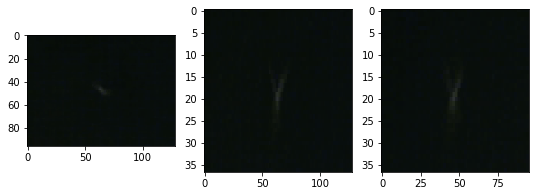

In [26]:
plot_sections(crop(zstack, axes=(1,2)), method="max")

In [29]:
plot_diagonal_sections(crop(zstack, axes=(1,2)), method="max")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEB56E37C8>,
      dtype=object)

In [30]:
nplab.current_datafile()

<HDF5 group "/" (2 members)>

In [ ]:
# abort a thread :(
import inspect
import ctypes
def _async_raise(tid, exctype):
    '''Raises an exception in the threads with id tid'''
    if not inspect.isclass(exctype):
        raise TypeError("Only types can be raised (not instances)")
    res = ctypes.pythonapi.PyThreadState_SetAsyncExc(ctypes.c_long(tid),
                                                     ctypes.py_object(exctype))
    if res == 0:
        raise ValueError("invalid thread id")
    elif res != 1:
        # "if it returns a number greater than one, you're in trouble,
        # and you should call it again with exc=NULL to revert the effect"
        ctypes.pythonapi.PyThreadState_SetAsyncExc(ctypes.c_long(tid), None)
        raise SystemError("PyThreadState_SetAsyncExc failed")

# get the thread's ID
def get_thread_id(t):
    assert t.is_alive(), "This only works for running threads."
    for id, obj in threading._active.items():
        if obj is t:
            return id
    raise KeyError("Couldn't find the supplied thread.")
    
_async_raise(get_thread_id(t), Exception)

# Adding the diffuser
Next, I swap the mirror for a diffuser, making sure to lower the stage in between and being very careful to avoid crashing the objective into the diffuser.  This is the right moment to align the illumination (mostly just using the mirror mount that controls the beamsplitter).  Once aligned, you should also take reference and background spectra.  NB there is both a pinhole and a fibre, so you'll probably want to tweak the small mirror (on a flip mount) that couples the fibre to the pinhole.

In [ ]:
f, axes = plt.subplots(1,2)
for ax, cam in zip(axes, cameras):
    ax.imshow(cam.raw_image())

NB the left image is the pinhole camera (camera 1) and the right is the overview/spotting scope (camera 2).  As you move through the focus, you can see wispy patterns on camera 1, indicating that you're at the focus of the paraboloid.

Now is also a good time to compare the position of the scattered pinhole image if you didn't do it with the mirror - though I usually just use the mirror.

In [ ]:
spectrometer.save_spectrum(attrs={"description":"A reference spectrum"})

In [ ]:
spectrometer.save_spectrum(attrs={"description":"A reference spectrum (with ND2 removed)"})

In [ ]:
for i in range(10):
    spectrometer.save_spectrum(attrs={"description":"A reference spectrum (with ND2 removed)"})

# Measuring with the sample
After getting the illumination about right, I swap to a NPoM sample.  Move around so you are looking at something that's roughly point like - you'll see crazy swirly shapes (again, use the reflected LED to check focus).  There's a point in the image that looks like the centre - you can move this using the tip/tilt adjusters on LP.  Note that each time you tweak them you'll need to adjust sample X, Y, and Z because the focus will shift significantly.

Once the central spot is co-aligned with the pinhole, you should be able to see particles focus to a nice point.

In [ ]:
f, axes = plt.subplots(1,2)
for ax, cam in zip(axes, cameras):
    ax.imshow(cam.raw_image())

In [42]:
cameras[0].save_raw_image()
def measure_images_and_spectrum(cameras, spectrometer, df):
    group = df.create_group("particle_%d")
    for cam in cameras:
        group.create_dataset("image_from_camera_%d", data=cam.raw_image())
    group.create_dataset("spectrum", data=spectrometer.read_spectrum(), attrs=spectrometer.metadata)
    return group

In [58]:
g = measure_images_and_spectrum(cameras,spectrometer, df)
g.attrs["description"] = "80nm gold NPoM, new sample :)"

In [ ]:
g = measure_images_and_spectrum(cameras,spectrometer, df)
g.attrs["description"] = "A dim particle (ref and bg should be correct, NB TEC is only -5 as lower causes instability...)"

In [ ]:
g = measure_images_and_spectrum(cameras,spectrometer, df)
g.attrs["description"] = "A bright particle - probably more than one!"

In [ ]:
group = nplab.current_datafile().create_group("hdr_zstack_%d")
group.attrs["note"] = "A dim particle"
t = threading.Thread(target=hdr_zstack_rel, args=(piezo, cameras[0], group),
                     kwargs={"exposures":[-1, -3, -5],
                             "voltages": np.arange(-10,11)*75/20*0.5})
t.start()

In [ ]:
zstack = extract_3d_image(group, 0)
w, h = zstack.shape[1:3]
plot_sections(zstack[:, w*2//5:w*3//5, h*2//5:h*3//5, ...], method="max")

In [32]:
def spectrometer_scan(cameras, spectrometer, piezo, datagroup,
                      voltages=np.linspace(-33.75, 33.75, 37),
                      axis="channel_0"):
    """Take images and spectra at every point along a line"""    
    datagroup.attrs['description'] = ("We move the piezo along a line, "
                                     "and record spectra and images at each point.")
    previous_voltage = piezo.select_axis(piezo.position, axis)
    for cam in cameras:
        dumped_image = cam.raw_image()
        ds = datagroup.create_dataset("initial_uncropped_image_%d", data=cam.raw_image())
        ds.attrs["piezo_output_voltages"] = piezo.output_voltages
    try:
        for voltage in voltages:
            if abort_event.is_set():
                break
            target_voltage = previous_voltage + voltage
            smooth_move(piezo, target_voltage, axis=axis)
            time.sleep(0.2)
            #print("Tried to move to {}, moved to {}".format(target_voltage, piezo.select_axis(piezo.position, axis)))
            piezo.move(target_voltage, axis=axis, relative=False)
            time.sleep(0.5)
            #print("Tried to move to {}, moved to {}".format(target_voltage, piezo.select_axis(piezo.position, axis)))
            vg = datagroup.create_group("position_%d", 
                                        attrs={"piezo_output_voltages":piezo.output_voltages})
            for cam in cameras:
                dumped_image = cam.raw_image()
                w, h = dumped_image.shape[:2]
                ds = vg.create_dataset("camera_%d", data=cam.raw_image()[w*2//5:w*3//5, h*2//5:h*3//5, ...])
                ds.attrs["piezo_output_voltages"] = piezo.output_voltages
            for i in range(5):
                ds = vg.create_dataset("spectrum_%d", data=spectrometer.read_spectrum(), attrs=spectrometer.metadata)
                ds.attrs["piezo_output_voltages"] = piezo.output_voltages
    finally:
        smooth_move(piezo, previous_voltage, axis=axis)


In [59]:
import threading
group = nplab.current_datafile().create_group("spectra_scan_%d")
group.attrs["note"] = "z stack of an 80nm nanoparticle"
t = threading.Thread(target=spectrometer_scan, args=(cameras, spectrometer, piezo, group),
                     kwargs={"axis":"channel_0",
                             "voltages": np.arange(-8,12)})
t.start()

In [50]:
def extract_spectra(group, use_reference=True):
    """Average together spectra and create a 2D stack vs position, wavelength
    """
    positions = group.numbered_items("position")
    for i, p in enumerate(positions):
        spectra = p.numbered_items("spectrum")
        if i==0:
            stack = np.zeros((len(positions), len(spectra)) + spectra[0].shape, dtype=spectra[0].dtype)
            wavelengths = spectra[0].attrs['wavelengths']
            try:
                background = spectra[0].attrs['background']
                reference = spectra[0].attrs['reference']
            except:
                print("warning: no background/reference saved")
            voltages = np.zeros((len(positions), 3))
        for j, s in enumerate(spectra):
            stack[i, j, ...] = s # should work for colour or single-channel
        voltages[i, :] = spectra[0].attrs['piezo_output_voltages']
    try:
        pass
        stack -= background[np.newaxis, np.newaxis, ...]
        if use_reference:
            stack /= (reference-background)[np.newaxis, np.newaxis, ...]
    except:
        print("Could not reference/background-subtract the spectra")
    return wavelengths, voltages, stack

def extract_images(group, camera=0):
    positions = group.numbered_items("position")
    voltages = np.zeros((len(positions), 3))
    for i, p in enumerate(positions):
        image = p.numbered_items("camera")[camera]
        if i==0:
            stack = np.zeros((len(positions), ) + image.shape, dtype=image.dtype)
        stack[i, ...] = image # should work for colour or single-channel
        voltages[i, :] = image.attrs['piezo_output_voltages']
    return voltages, stack

def plot_spectrometer_scan_1d(group):
    wavelengths, voltages, stack = extract_spectra(group)
    moving_axis = np.argmax(np.std(voltages, axis=0))
    f, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].imshow(stack.mean(axis=1)[:,150:1000], aspect="auto", vmin=0, vmax=0.02)
    
    wavelengths, voltages, stack = extract_spectra(group, use_reference=False)
    ax[1].plot(voltages[:,moving_axis]/75*20, stack[:,:,150:1000].mean(axis=(1,2)), "-o")
    ax[1].set_xlabel("Position/um")
    ax[1].set_ylabel("Intensity")

def plot_image_scan_1d(group,camera=0):
    voltages, stack = extract_images(group, camera=camera)
    f, ax = plt.subplots(1,2, figsize=(8,3))
    peak = np.unravel_index(np.argmax(stack.max(axis=(0,3))), stack.shape[1:3])
    print(peak)
    ax[0].imshow(stack[:,peak[0],:,:], aspect="auto")
    ax[1].plot(stack[:,peak[0],peak[1],:])

(0, 35)


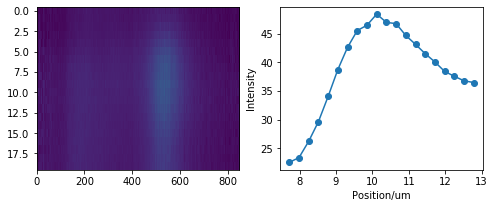

In [60]:
plot_spectrometer_scan_1d(group)
plot_image_scan_1d(group, camera=1)

In [ ]:
group = nplab.current_datafile().create_group("spectra_scan_%d")
group.attrs["note"] = "A dimmer particle, focused manually in XYZ beforehand."
t = threading.Thread(target=spectrometer_scan, args=(cameras, spectrometer, piezo, group),
                     kwargs={"axis":"channel_0",
                             "voltages":np.arange(-7, 8)})
t.start()

In [ ]:
plot_wavelength_scan_1d(group)
plot_image_scan_1d(group)

In [61]:
def smooth_move_3d(piezo, pos, dx=1, dt=0.2):
    """Move the piezo smoothly (should this be built in to the class?)"""
    oldpos = np.array(piezo.position)
    distance = np.sum((pos-oldpos)**2)**0.5
    N = int(distance//dx)
    for i in range(N, 0, -1):
        newpos = pos - np.float(i/N) * (pos - oldpos)
        piezo.move(newpos, relative=False)
        time.sleep(dt)
    piezo.move(pos, relative=False)

def spectrometer_scan_3d(cameras, spectrometer, piezo, datagroup,
                      voltages=[np.arange(-6,7),]*3, vectors=[[1,0,0],[0,1,0],[0,0,1]]):
    """Take images and spectra at every point in a volume"""    
    datagroup.attrs['description'] = ("We move the piezo in a raster pattern, "
                                     "and record spectra and images at each point.")
    previous_voltages = piezo.output_voltages
    for cam in cameras:
        dumped_image = cam.raw_image()
        ds = datagroup.create_dataset("initial_uncropped_image_%d", data=cam.raw_image())
        ds.attrs["piezo_output_voltages"] = piezo.output_voltages
    try:
        initial_move = True
        for v0 in voltages[0]:
            for v1 in voltages[1]:
                for v2 in voltages[2]:
                    if abort_event.is_set():
                        break
                    target_voltages = np.array(previous_voltages)
                    for vv, vector in zip([v0,v1,v2], vectors):
                        target_voltages += vv * np.array(vector)
                    if initial_move: #(np.sum((piezo.output_voltages - target_voltages)**2)**0.5 > 5):
                        smooth_move_3d(piezo, target_voltages)
                        time.sleep(1)
                        initial_move = False
                    #print("Tried to move to {}, moved to {}".format(target_voltage, piezo.select_axis(piezo.position, axis)))
                    piezo.move(target_voltages, relative=False)
                    time.sleep(0.5)
                    #print("Tried to move to {}, moved to {}".format(target_voltage, piezo.select_axis(piezo.position, axis)))
                    vg = datagroup.create_group("position_%d", 
                                                attrs={"piezo_output_voltages":piezo.output_voltages,
                                                       "target_voltages":target_voltages})
                    for cam in cameras:
                        dumped_image = cam.raw_image()
                        w, h = dumped_image.shape[:2]
                        ds = vg.create_dataset("camera_%d", data=cam.raw_image()[w*2//5:w*3//5, h*2//5:h*3//5, ...])
                        ds.attrs["piezo_output_voltages"] = piezo.output_voltages
                    for i in range(5):
                        ds = vg.create_dataset("spectrum_%d", data=spectrometer.read_spectrum(), attrs=spectrometer.metadata)
                        ds.attrs["piezo_output_voltages"] = piezo.output_voltages
    finally:
        smooth_move_3d(piezo, previous_voltages)
        #piezo.move(previous_voltages, relative=False)



In [62]:
group = nplab.current_datafile().create_group("spectra_scan_3d_%d")
group.attrs["note"] = "A dimmer particle, focused manually in XYZ beforehand."
t = threading.Thread(target=spectrometer_scan_3d, args=(cameras, spectrometer, piezo, group),
                     kwargs={"voltages":[np.arange(-5,6),np.arange(-4, 5),[-1,0,1]],
                             "vectors":[[1,0,0],[0,1,1],[0,1,-1]]})
t.start()

In [ ]:
def scan_sections(cameras, spectrometer, piezo, group, 
                  z_voltages=np.arange(-5,6), xy_voltages=np.arange(-4,5), 
                  orthogonal_voltages=[0]):
    for vectors in [[[1,0,0],[0,1,0],[0,0,1],],
                    [[1,0,0],[0,0,1],[0,1,0],],
                    [[1,0,0],[0,1,1]/np.sqrt(2),[0,1,-1]/np.sqrt(2),],
                    [[1,0,0],[0,1,-1]/np.sqrt(2),[0,1,1]/np.sqrt(2),],
                   ]:
        sg = group.create_group("spectra_scan_3d_%d")
        spectrometer_scan_3d(cameras, spectrometer, piezo, sg,
                            voltages=[z_voltages, xy_voltages, orthogonal_voltages],
                            vectors=vectors)
    sg = group.create_group("spectra_scan_3d_%d")
    spectrometer_scan_3d(cameras, spectrometer, piezo, sg,
                            voltages=[[0], xy_voltages, xy_voltages])

In [ ]:
group = nplab.current_datafile().create_group("spectral_sections_%d")
group.attrs["note"] = "A dimmer particle, focused manually in XYZ beforehand."
t = threading.Thread(target=scan_sections, args=(cameras, spectrometer, piezo, group),
                     kwargs={#"voltages":[np.arange(-5,6),np.arange(-4, 5),[-1,0,1]],
                             #"vectors":[[1,0,0],[0,1,1],[0,1,-1]]
                     })
t.start()

In [ ]:
smooth_move_3d(piezo, [37.5,]*3)

In [ ]:
t.is_alive()

In [ ]:
from tqdm.auto import tqdm
positions = np.array([p.attrs['target_voltages'] for p in group.numbered_items("position")])
plt.plot(positions[:,0], positions[:,1], "o-")

def find_position_grid(group, tolerance=0.1):
    voltages = [[],[],[]]
    for p in group.numbered_items("position"):
        pv = p.attrs['target_voltages']
        for i in range(len(voltages)):
            vs = np.array(voltages[i])
            if len(vs) == 0 or np.min(np.abs(vs - pv[i])) > tolerance:
                voltages[i].append(pv[i])
    return [np.array(vs) for vs in voltages]

def hypercube(group, tolerance=0.1):
    voltages = find_position_grid(group, tolerance)
    hypercube = None
    for p in (group.numbered_items("position")):
        spectra = p.numbered_items("spectrum")
        spectrum = np.mean(spectra, axis=0)
        try:
            spectrum -= spectra[0].attrs['background']
        except:
            print("Failed to background-subtract")
        target_voltages = p.attrs['target_voltages']
        
        if hypercube is None:
            hypercube = np.zeros(tuple([len(v) for v in voltages]) + (len(spectrum),), spectrum.dtype)
        index = tuple([np.argmin(np.abs(voltages[i] - target_voltages[i])) for i in range(3)])
        hypercube[index + (slice(None),)] = spectrum
    return hypercube
hc = hypercube(group)
plt.imshow(hc.max(axis=(2,3)))
        

In [ ]:
hc.shape

In [ ]:
f = plt.figure(figsize=(12,12))
for i in range(16):
    ax = f.add_subplot(4,4,i+1)
    ax.imshow(hc.mean(axis=(3))[i,:,:])

In [63]:
smooth_move_3d(piezo, [0,0,0])
nplab.current_datafile().close()

stopping live view thread
stopping live view thread


In [ ]:
for axn in piezo.axis_names:
    smooth_move(piezo, 37.5, axn)
df = nplab.current_datafile()